## **Import Libraries**

In [2]:
import mne

# Utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from utilities import read_xdf, epoching

In [457]:
# Train model
from collections import OrderedDict
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from time import time
from datetime import timedelta
import keras
from keras.models import load_model
import os
from keras.utils import plot_model

# Build model
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking,LSTM, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D
from keras.layers import Concatenate, Lambda, Reshape, RepeatVector,Multiply, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K                                                          
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

# Classifications report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay ,multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

## **Load Data**

### From XDF file

In [458]:
annotations_des = {
    '1': 'Left cue start',
    '2': 'Left stimuli start',
    '3': 'Left blank start',
    '4': 'Right cue start',
    '5': 'Right stimuli start',
    '6': 'Right blank start',
}

In [ ]:
from utilities import read_xdf, epoching

filenames = {'Pipo_1_5_test1.xdf', 'Pipo_1_5_test2.xdf', 'Pipo_1_5_test3.xdf'}

X, F, t, y = [],[],[],[]
for filename in filenames:

    raw = read_xdf(filename, show_plot=False, show_psd=False, bandpass=(4.0, 12.0))

    epochs = epoching(raw, show_psd=False,
        tmax=5) # tmax=5 means set epoch duration 5 second

    # Pick only event 2: Left stimuli, 5: Right stimuli
    epochs = epochs['2','5']

    X.append((  epochs.get_data() * 1e6)[:,:,:1250]) # select only first 1250 frames(approx 5 second)
    F.append(   epochs.compute_psd(method='welch', fmax=30).get_data())
    t.append((  epochs.times)[:1250])                # select only first 1250 frames(approx 5 second)
    y.append(   epochs.events[:, -1])

# Concatenate all data
X = np.concatenate(X)
F = np.concatenate(F)
t = np.concatenate(t)
y = np.concatenate(y)

In [12]:
X.shape, F.shape, t.shape, y.shape

((48, 5, 1250), (48, 5, 31), (3750,), (48,))

In [14]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
Y = enc.fit_transform(y.reshape(-1, 1)).toarray()

In [15]:
X.shape, F.shape, t.shape, Y.shape

((48, 5, 1250), (48, 5, 31), (3750,), (48, 2))

### From CSV file

In [ ]:
# Load data
df = pd.read_csv('data/epochs.csv')

# Split data into training and testing sets
train_dataset = df.sample(frac=0.9,random_state=0)
test_dataset = df.drop(train_dataset.index).sample(frac=1.0,random_state=0)

train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

train_dataset

## **Cross-validation**: evaluating estimator performance

💡 [scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance)

### 4-different machine learning pipelines

💡 [EEG Notebook](https://neurotechx.github.io/eeg-notebooks/auto_examples/visual_ssvep/02r__ssvep_decoding.html)

CSP + RegLDA
Cov + TS
Cov + MDM
CSP + Cov + TS


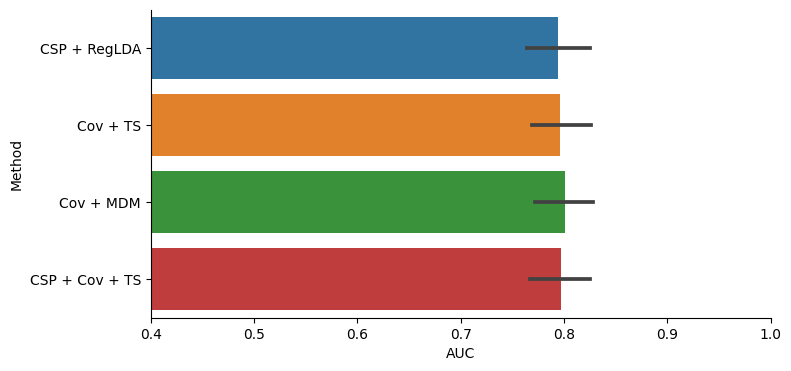

In [ ]:
# Next, we will use 4 different machine learning pipelines to classify the SSVEP based on the data we collected. The

# - CSP + RegLDA : Common Spatial Patterns + Regularized Linear Discriminat Analysis. This is a very common EEG analysis pipeline.
# - Cov + TS : Covariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipelines.
# - Cov + MDM: Covariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.
# - CSP + Cov + TS: Common Spatial Patterns + Covariance + Tangent spacem mapping. Riemannian pipeline with the standard CSP procedure beforehand

# Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

# Note: because we're doing machine learning here, the following cell may take a while to complete

clfs = OrderedDict()
clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())

# define cross validation
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25,
                                        random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc',cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 1)
sns.despine()
plt.show()

## **Training pipeline**

### Train Test Split

In [469]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [470]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [471]:
X_train

<tf.Tensor: shape=(38, 5, 1251), dtype=float32, numpy=
array([[[        0.   ,  -1003381.2  ,  -1725189.   , ...,
          -2098587.2  ,  -3552768.2  ,  -5270521.5  ],
        [        0.   ,  -1007949.4  ,  -1579501.2  , ...,
            407493.1  ,  -1102869.9  ,  -2933766.5  ],
        [        0.   ,   -766858.75 ,  -1013545.94 , ...,
            481599.78 ,   -704088.5  ,  -2155044.8  ],
        [        0.   ,    -30126.305,    495850.7  , ...,
           1894179.9  ,   1130032.   ,    257660.   ],
        [        0.   ,    924085.4  ,   2462104.8  , ...,
           1194990.   ,   1064271.2  ,   1084424.9  ]],

       [[        0.   ,  -3077814.   ,  -7004395.   , ...,
          -9488472.   , -10868839.   , -12474449.   ],
        [        0.   ,  -3135845.   ,  -6971538.5  , ...,
          -4187086.2  ,  -6328298.5  ,  -8899886.   ],
        [        0.   ,  -2087636.1  ,  -4458084.5  , ...,
           1579381.1  ,   -688799.94 ,  -3530024.   ],
        [        0.   ,  -21354

In [472]:
y_train

<tf.Tensor: shape=(38, 2), dtype=int32, numpy=
array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])>

### **Create a model**

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 5, 1251)]         0         
                                                                 
 conv1d_38 (Conv1D)          (None, 3, 128)            480512    
                                                                 
 batch_normalization_24 (Bat  (None, 3, 128)           512       
 chNormalization)                                                
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 1, 128)            0         
                                                                 
 dense_82 (Dense)            (None, 1, 64)             825

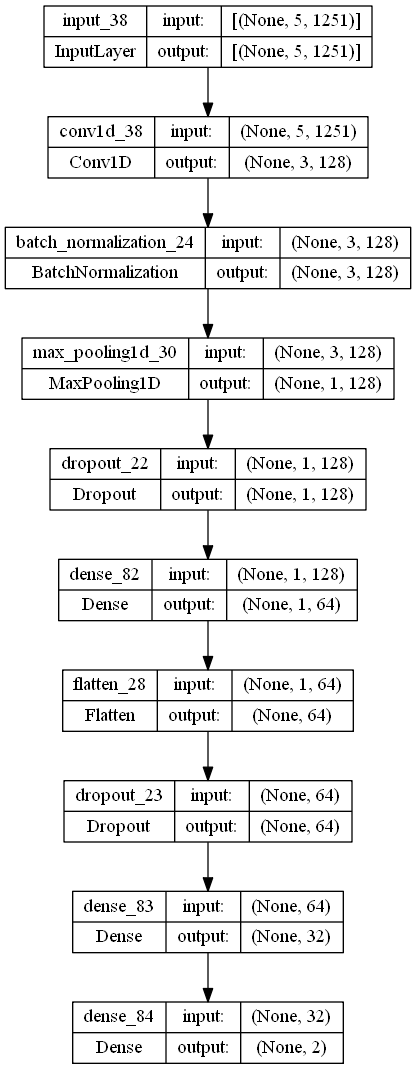

In [473]:
input_shape = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(128, 3, activation='relu')(input_shape)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=input_shape, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True)

In [474]:
model.fit(X_train, y_train, epochs=3, batch_size=4)

Epoch 1/3
10/10 [==============================] - 2s 9ms/step - loss: 0.8120 - accuracy: 0.6316
Epoch 2/3
10/10 [==============================] - 0s 10ms/step - loss: 0.4036 - accuracy: 0.7895
Epoch 3/3
10/10 [==============================] - 0s 11ms/step - loss: 0.2200 - accuracy: 0.9474


### **Evaluate the model**

In [475]:
predictions = model.predict(X_test)
predictions

1/1 [==============================] - 0s 164ms/step


array([[1.08638528e-06, 9.99998927e-01],
       [9.79493439e-01, 2.05065627e-02],
       [9.16130364e-01, 8.38696063e-02],
       [8.03550005e-01, 1.96449995e-01],
       [1.04084225e-04, 9.99895930e-01],
       [5.21297334e-04, 9.99478757e-01],
       [1.16377193e-02, 9.88362253e-01],
       [1.56506183e-04, 9.99843478e-01],
       [9.99853611e-01, 1.46387305e-04],
       [4.43555275e-03, 9.95564461e-01]], dtype=float32)

In [476]:
# Convert predictions to binary
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 0, 0, 0, 1, 1, 1, 1, 0, 1], dtype=int64)

In [477]:
# Classification report
print(classification_report(np.argmax(y_test, axis=1), predictions))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

